In [1]:
import sys
sys.path.insert(1, './custom_modules')

In [2]:
#### create config
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 256
    channels = 1
    train_batch_size = 4 
    eval_batch_size = 4  
    num_epochs = 170
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    evaluate_epochs = 5 # adjust to num_epochs
    evaluate_num_batches = -1 # ~3s/batch. 2.5 min/Evaluation 3D epoch with all batches  
    deactivate3Devaluation = False
    evaluate_3D_epochs = 1000  # 3 min/Evaluation 3D
    save_model_epochs = 100
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "lesion-synthesis-256-unconditioned"  # the model name locally and on the HF Hub
    dataset_train_path = "./datasets/synthesis/dataset_train/imgs"
    segm_train_path = "./datasets/synthesis/dataset_train/segm"
    masks_train_path = "./datasets/synthesis/dataset_train/masks"
    dataset_eval_path = "./datasets/synthesis/dataset_eval/imgs"
    segm_eval_path = "./datasets/synthesis/dataset_eval/segm"
    masks_eval_path = "./datasets/synthesis/dataset_eval/masks"
    train_only_connected_masks=False  # No Training with lesion masks
    eval_only_connected_masks=False 
    num_inference_steps=50
    add_lesion_technique = "mean_intensity" # 'mean_intensity' or 'other_lesions'
    intermediate_timestep = 25
    mode = "eval" # 'train' or 'eval'
    debug = True 

    push_to_hub = False  # whether to upload the saved model to the HF Hub 
    seed = 0
config = TrainingConfig()

In [3]:
if config.debug:
    #config.num_inference_steps = 1
    config.train_batch_size = 1
    config.eval_batch_size = 1 
    config.train_only_connected_masks=False
    config.eval_only_connected_masks=False
    config.evaluate_num_batches = 1
    config.deactivate3Devaluation = False
    #dataset_train_path = "./dataset_eval/imgs"
    #segm_train_path = "./dataset_eval/segm"
    #masks_train_path = "./dataset_eval/masks"   

In [4]:
#setup huggingface accelerate
import torch
import numpy as np
import accelerate
accelerate.commands.config.default.write_basic_config(config.mixed_precision)

Configuration already exists at /home/jovyan/.cache/huggingface/accelerate/default_config.yaml, will not override. Run `accelerate config` manually or pass a different `save_location`.


False

In [5]:
from DatasetMRI2D import DatasetMRI2D
from DatasetMRI3D import DatasetMRI3D
from pathlib import Path

#create dataset
datasetTrain = DatasetMRI2D(root_dir_img=Path(config.dataset_train_path), root_dir_segm=Path(config.segm_train_path), only_connected_masks=config.train_only_connected_masks, directDL=False)
datasetEvaluation = DatasetMRI2D(root_dir_img=Path(config.dataset_eval_path), root_dir_segm=Path(config.segm_eval_path), root_dir_masks=Path(config.masks_eval_path), root_dir_synthesis=Path(config.masks_eval_path), only_connected_masks=config.eval_only_connected_masks, directDL=False)
dataset3DEvaluation = DatasetMRI3D(root_dir_img=Path(config.dataset_eval_path), root_dir_segm=Path(config.segm_eval_path), root_dir_masks=Path(config.masks_eval_path), root_dir_synthesis=Path(config.masks_eval_path), only_connected_masks=config.eval_only_connected_masks, directDL=False)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

### Finding good intensity of lesions

from pathlib import Path
import nibabel as nib
from tqdm.auto import tqdm
from DatasetMRI3D import DatasetMRI3D 

t1w_norm_noskull_list = list(Path("temp/unhealthy_DL+DiReCT_Segmentation").rglob("*T1w_norm_noskull.nii.gz"))
lesion_list = list(Path("temp/unhealthy_registered_lesions").rglob("*transformed_lesion.nii.gz"))

t1ws = list()
lesions = list()
for i in tqdm(range(len(t1w_norm_noskull_list))):
    t1w = nib.load(t1w_norm_noskull_list[i])
    t1w = t1w.get_fdata()
    t1w, _ = DatasetMRI3D.preprocess(t1w)
    lesion = nib.load(lesion_list[i])
    lesion = lesion.get_fdata()
    lesion = DatasetMRI3D._padding(torch.from_numpy(lesion).to(torch.uint8))
    #means.append(t1w[lesion.to(torch.bool)].mean())
    #stds.append(t1w[lesion.to(torch.bool)].std())
    t1ws.append(t1w)
    lesions.append(lesion)
t1w_big = torch.cat(t1ws)
lesion_big = torch.cat(lesions)

print("mean lesion intensity: ", t1w_big[lesion_big.to(torch.bool)].mean()) # -0.3572
print("std lesion intensity: ", t1w_big[lesion_big.to(torch.bool)].std()) # 0.1829
print("median lesion intensity: ", t1w_big[lesion_big.to(torch.bool)].median()) # 0.1829

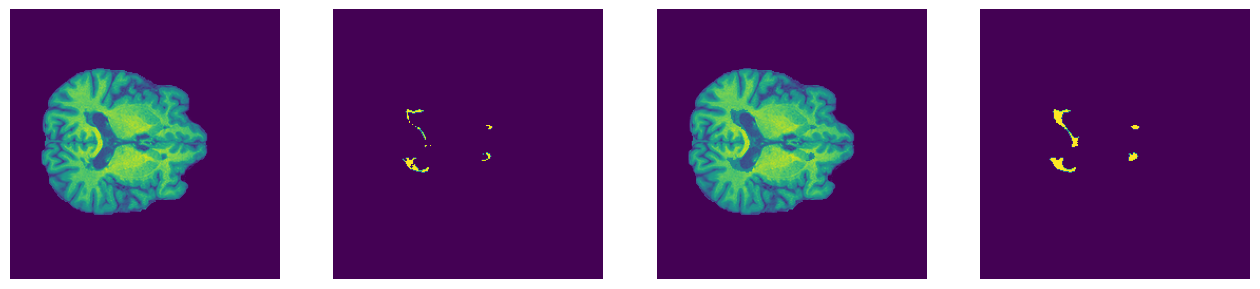

In [6]:
import matplotlib.pyplot as plt 
import random 
 
torch.manual_seed(7) 
random_idx = torch.randint(len(datasetEvaluation)-1, size=(1,)).item()

fig, axis = plt.subplots(1,4, figsize=(16,4)) 
img = datasetEvaluation[random_idx]["gt_image"].squeeze()
img[datasetEvaluation[random_idx]["mask"].to(torch.bool).squeeze()] = -0.5492 # mean-std of lesion intensity
axis[0].imshow(datasetEvaluation[random_idx]["gt_image"].squeeze()/2+0.5)
axis[0].set_axis_off()
axis[1].imshow(datasetEvaluation[random_idx]["mask"].squeeze())
axis[1].set_axis_off()
axis[2].imshow(img/2+0.5)
axis[2].set_axis_off()
axis[3].imshow(datasetEvaluation[random_idx]["synthesis"].squeeze())
axis[3].set_axis_off()
fig.show()

### Training

In [7]:
#create model
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=config.channels,  # the number of input channels, 3 for RGB images
    out_channels=config.channels,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

config.model = "UNet2DModel"

In [8]:
#setup noise scheduler
import torch
from PIL import Image
from diffusers import DDIMScheduler

noise_scheduler = DDIMScheduler(num_train_timesteps=1000)

config.noise_scheduler = "DDIMScheduler(num_train_timesteps=1000)"

In [9]:
# setup lr scheduler
from diffusers.optimization import get_cosine_schedule_with_warmup
import math

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(math.ceil(len(datasetTrain)/config.train_batch_size) * config.num_epochs), # num_iterations per epoch * num_epochs
)
config.lr_scheduler = "cosine_schedule_with_warmup"

In [10]:
from TrainingUnconditional import TrainingUnconditional
from DDIMGuidedPipeline import DDIMGuidedPipeline
from Evaluation2DSynthesis import Evaluation2DSynthesis
from Evaluation3DSynthesis import Evaluation3DSynthesis 
import PipelineFactories

config.conditional_data = "None"

args = {
    "config": config, 
    "model": model, 
    "noise_scheduler": noise_scheduler, 
    "optimizer": optimizer, 
    "lr_scheduler": lr_scheduler, 
    "datasetTrain": datasetTrain, 
    "datasetEvaluation": datasetEvaluation, 
    "dataset3DEvaluation": dataset3DEvaluation, 
    "evaluation2D": Evaluation2DSynthesis,
    "evaluation3D": Evaluation3DSynthesis, 
    "pipelineFactory": PipelineFactories.get_ddim_guided_pipeline, 
    "deactivate3Devaluation": config.deactivate3Devaluation} 
trainingSynthesis = TrainingUnconditional(**args) 

2024-04-10 08:51:52.441372: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-10 08:51:52.709505: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-10 08:51:52.709572: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-10 08:51:52.709632: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-10 08:51:52.756988: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-10 08:51:52.758646: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [11]:
if config.mode == "train":
    trainingSynthesis.train()

In [12]:
if config.mode == "eval":
    pipeline = DDIMGuidedPipeline.from_pretrained(config.output_dir) 
    trainingSynthesis.evaluate(pipeline)

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

self.scheduler.timesteps[timestep:]:  tensor([480, 460, 440, 420, 400, 380, 360, 340, 320, 300, 280, 260, 240, 220,
        200, 180, 160, 140, 120, 100,  80,  60,  40,  20,   0])
self.scheduler.timesteps:  tensor([980, 960, 940, 920, 900, 880, 860, 840, 820, 800, 780, 760, 740, 720,
        700, 680, 660, 640, 620, 600, 580, 560, 540, 520, 500, 480, 460, 440,
        420, 400, 380, 360, 340, 320, 300, 280, 260, 240, 220, 200, 180, 160,
        140, 120, 100,  80,  60,  40,  20,   0])


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f528c5dde40>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/multiprocessing/connection.py", line 947, in wait
    ready = selector.select(timeout)
            ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/selectors.py", line 415, in select
    fd_event_list = self._sele

KeyboardInterrupt: 

In [ ]:
print("Finished Training")

In [14]:
#create python script for ubelix 
import os

!jupyter nbconvert --to script "lesion_synthesis_unconditioned.ipynb"
filename="lesion_synthesis_unconditioned.py"

# delete this cell from python file
lines = []
with open(filename, 'r') as fp:
    lines = fp.readlines()
with open(filename, 'w') as fp:
    for number, line in enumerate(lines):
        if number < len(lines)-17: 
            fp.write(line)

[NbConvertApp] Converting notebook lesion_synthesis_unconditioned.ipynb to script
[NbConvertApp] Writing 8448 bytes to lesion_synthesis_unconditioned.py
